# Introduction to Machine Learning
## Project Phase 2

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import random
from sympy import mod_inverse
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [3]:
mnist = fetch_openml('mnist_784', version=1)
x_data = mnist.data.to_numpy()
y_data = mnist.target.to_numpy().astype(int)

We devide the data into test and train datas an also, use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [4]:
x_data = (x_data > 127).astype(np.float32)
x_train, x_test = x_data[:60000], x_data[60000:]
y_train, y_test = y_data[:60000], y_data[60000:]
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

Making the labels one-hot:

In [5]:
ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

The plot to show the samples:

In [6]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

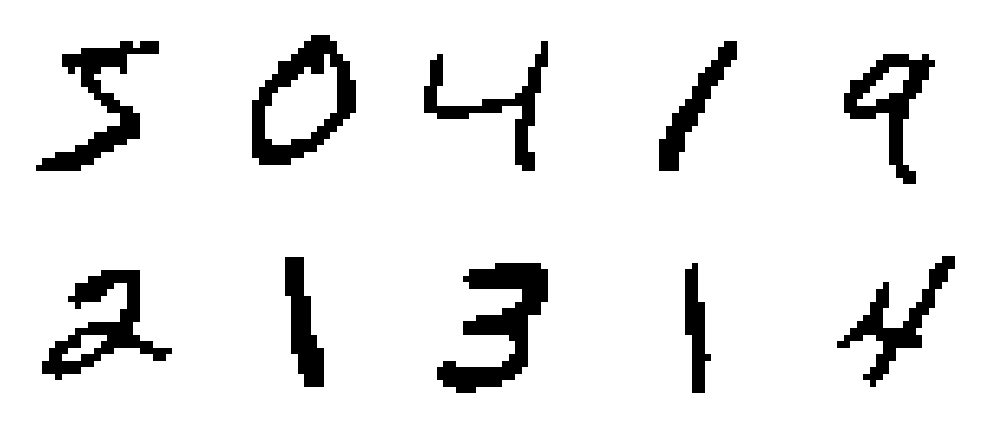

In [8]:
show_samples(x_train[:10])

## Simple Boltzman machine:

The Boltzmann machine is like the one we used in the first phase of the project and follow the same patterns to update the parameters.

In [31]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, hid, k):
        v_prob_0 = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        v = self.sample(v_prob_0)
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):
        h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_sample_0 = self.sample(h_prob_0)

        v_neg = v.copy()

        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob_neg)

        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

        positive_grad = np.dot(v.T, h_prob_0)
        negative_grad = np.dot(v_neg.T, h_prob_neg)

        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

        return v_neg

    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = []
        for i in range(n_samples):
            sample = np.random.binomial(1, 0.5, self.n_hidden)
            sample = self.gibbs_sampling(sample, k)
            samples.append(sample)
        return np.array(samples)

Based on the simulations in phase 1 we define the number of hidden layers and k as follow:

In [32]:
n_visible = x_train.shape[1]
n_hidden = 32
k_values = [1, 5, 10]

Now we train the model on the MNIST dataset:

In [33]:
# training
rbms = {}
for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(x_train, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00199
Epoch 2/10, Loss: 0.00161
Epoch 3/10, Loss: 0.00153
Epoch 4/10, Loss: 0.00150
Epoch 5/10, Loss: 0.00148
Epoch 6/10, Loss: 0.00146
Epoch 7/10, Loss: 0.00146
Epoch 8/10, Loss: 0.00145
Epoch 9/10, Loss: 0.00144
Epoch 10/10, Loss: 0.00144
Training RBM with k=5
Epoch 1/10, Loss: 0.00220
Epoch 2/10, Loss: 0.00174
Epoch 3/10, Loss: 0.00164
Epoch 4/10, Loss: 0.00158
Epoch 5/10, Loss: 0.00155
Epoch 6/10, Loss: 0.00153
Epoch 7/10, Loss: 0.00152
Epoch 8/10, Loss: 0.00150
Epoch 9/10, Loss: 0.00150
Epoch 10/10, Loss: 0.00149
Training RBM with k=10
Epoch 1/10, Loss: 0.00231
Epoch 2/10, Loss: 0.00182
Epoch 3/10, Loss: 0.00171
Epoch 4/10, Loss: 0.00164
Epoch 5/10, Loss: 0.00161
Epoch 6/10, Loss: 0.00158
Epoch 7/10, Loss: 0.00156
Epoch 8/10, Loss: 0.00155
Epoch 9/10, Loss: 0.00154
Epoch 10/10, Loss: 0.00153


As you can see, the model is converging and the loss is getting lower to a fixed point.

As we increase k, the final loss of the model on the training data is not getting better but based on the results of the first phase, we know that the model with a higher k performs better on the test datas and gives better resuls.

To test these models, we use the test dataset of the MNIST:

In [34]:
def evaluate_rbm(rbm, data):
    loss = 0
    for i in range(0, len(data), 64):
        batch = data[i:i+64]
        v_neg = rbm.contrastive_divergence(batch, k=1)
        loss += np.mean((batch - v_neg) ** 2)
    avg_loss = loss / (len(data) / 64)
    return avg_loss

In [35]:
simple_losses = {}
for k in k_values:
    loss = evaluate_rbm(rbms[k], x_test)
    simple_losses[k] = loss
    print(f"Simple RBM with k={k} Test Loss: {loss:.5f}")

Simple RBM with k=1 Test Loss: 0.09149
Simple RBM with k=5 Test Loss: 0.08900
Simple RBM with k=10 Test Loss: 0.08845


The test loss is getting better by increasing k. This confirms the results discussed in the phase 1.

## The Secure Boltzman Machine:

As we learned from the project file, the Secure Boltzmann Machine works with two parties. Each party have a specific number of parameters and each have they're own weights and biases.

To update the parameters, we use ElGamal encryption so that both models can calculate loss with needed values (e.g. $v_1h_2$). To implement this, we approach like the model below:

In [25]:
class SecureRBM:
    def __init__(self, n_visible, n_hidden, mA, learning_rate=0.001, p=467):
        """
        Initialize SecureRBM for two parties A and B.

        Parameters:
        - n_visible: total number of visible neurons (e.g., 784 for MNIST).
        - n_hidden: number of hidden neurons.
        - mA: number of visible features belonging to Party A.
          (Then mB = n_visible - mA belong to Party B.)
        - learning_rate: learning rate for weight updates.
        - p: a prime number used for the ElGamal-based secure operations.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.mA = mA
        self.mB = n_visible - mA
        self.learning_rate = learning_rate
        self.p = p

        limit = np.sqrt(6 / (self.n_visible + self.n_hidden))
        self.W = np.random.uniform(-limit, limit, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def generate_keys(self):
        """
        Generate ElGamal public and private keys.
        """
        g = random.randint(2, self.p - 2)
        x = random.randint(1, self.p - 2)
        y = pow(g, x, self.p)
        return (self.p, g, y), x

    def encrypt(self, public_key, message):
        """
        Encrypt a message (an integer) using the public key.
        """
        p, g, y = public_key
        k = random.randint(1, p - 2)
        c1 = pow(g, k, p)
        c2 = (int(message) * pow(y, k, p)) % p
        return (c1, c2)

    def decrypt_partial(self, private_key, public_key, ciphertext):
        """
        Partially decrypt a ciphertext using the private key.
        """
        p, g, y = public_key
        c1, c2 = ciphertext
        s = pow(c1, private_key, p)
        return (c2, s)

    def decrypt_final(self, partially_decrypted, p):
        """
        Final decryption using the modular inverse.
        """
        c2, s = partially_decrypted
        s_inv = mod_inverse(s, p)
        message = (c2 * s_inv) % p
        return message

    def sample_hidden_secure(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the hidden layer using contributions from both parties.

        Parameters:
        - v: input visible data (batch, n_visible)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: random mask array (batch, n_hidden)

        Returns:
        - Binary samples for hidden layer (batch, n_hidden)
        """
        vA = v[:, :self.mA]
        vB = v[:, self.mA:]

        WA = self.W[:self.mA, :]
        WB = self.W[self.mA:, :]

        act_A = np.dot(vA, WA) + self.h_bias
        act_B = np.dot(vB, WB)

        joint_act = act_A + act_B
        final_act = joint_act - random_r
        h_prob = self.sigmoid(final_act)
        return self.sample(h_prob)

    def sample_visible_secure(self, h, public_key_a, private_key_a, public_key_b, private_key_b, random_r):
        """
        Securely sample the visible layer.

        Parameters:
        - h: hidden layer activations (batch, n_hidden)
        - public_key_a, private_key_a: keys for Party A
        - public_key_b, private_key_b: keys for Party B
        - random_r: **Separate random masks for A and B (tuple of two arrays)**

        Returns:
        - Binary reconstruction of the visible layer (batch, n_visible)
        """
        random_r_A, random_r_B = random_r

        WA_T = self.W[:self.mA, :].T
        WB_T = self.W[self.mA:, :].T

        bA = self.v_bias[:self.mA]
        bB = self.v_bias[self.mA:]

        act_A = np.dot(h, WA_T) + bA
        act_B = np.dot(h, WB_T) + bB

        act_A = act_A - random_r_A
        act_B = act_B - random_r_B

        # Now concatenate securely processed activations
        joint_act = np.concatenate([act_A, act_B], axis=1)

        v_prob = self.sigmoid(joint_act)
        return self.sample(v_prob)


    def secure_compute(self, partial_activation, public_key, private_key):
        result = np.zeros_like(partial_activation)
        for i in range(partial_activation.shape[0]):
            for j in range(partial_activation.shape[1]):
                value = int(partial_activation[i, j])
                ciphertext = self.encrypt(public_key, value)
                dec = self.decrypt_final(self.decrypt_partial(private_key, public_key, ciphertext), self.p)
                result[i, j] = dec
        return result

    def reconstruct(self, v, public_key_a, private_key_a, public_key_b, private_key_b, random_r_hidden, random_r_visible):
        """
        Securely reconstruct the visible input using separate random masks for the hidden and visible layers.
        """
        h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r_hidden)
        v_recon = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r_visible)
        return v_recon

    def contrastive_divergence_secure(self, v, k, public_key_a, private_key_a, public_key_b, private_key_b):
        """
        Perform secure Contrastive Divergence.
        Generates separate random masks for hidden and visible layers.
        """
        mask_scale = 0.1
        batch_size = v.shape[0]
        random_r_hidden = np.random.randint(1, int(self.p * mask_scale), size=(batch_size, self.n_hidden))
        random_r_visible = np.random.randint(1, int(self.p * mask_scale), size=(batch_size, self.n_visible))

        v_neg = v.copy()
        for _ in range(k):
            mA = self.mA
            part_A = np.dot(v_neg[:, :mA], self.W[:mA, :])
            part_B = np.dot(v_neg[:, mA:], self.W[mA:, :])

            secure_A = self.secure_compute(part_A, public_key_a, private_key_a)
            secure_B = self.secure_compute(part_B, public_key_b, private_key_b)

            joint_act = secure_A + secure_B + self.h_bias
            final_act = joint_act - random_r_hidden
            h_prob = self.sigmoid(final_act)
            h_sample = self.sample(h_prob)

            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob)

        positive_grad = np.dot(v.T, h_prob)
        negative_grad = np.dot(v_neg.T, h_prob)

        # Gradient clipping to avoid instability
        grad_norm = np.linalg.norm(positive_grad - negative_grad)
        if grad_norm > 5.0:
            positive_grad = (positive_grad / grad_norm) * 5.0
            negative_grad = (negative_grad / grad_norm) * 5.0

        # Update weights
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob - h_prob, axis=0)
        return v_neg

    def train_secure(self, X_train_A, X_train_B, epochs=10, k=1, batch_size=64,
                 public_key_a=None, private_key_a=None,
                 public_key_b=None, private_key_b=None):
        """
        Train SecureRBM using secure Contrastive Divergence for two parties (A and B).
        """
        num_batches = len(X_train_A) // batch_size
        mask_scale = 0.1

        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train_A), batch_size):
                batch_A = X_train_A[i:i + batch_size]
                batch_B = X_train_B[i:i + batch_size]
                batch_size_local = batch_A.shape[0]

                # Generate separate random masks for Party A and B
                random_r_hidden = np.random.randint(1, int(self.p * mask_scale), size=(batch_size_local, self.n_hidden))
                random_r_visible_A = np.random.randint(1, int(self.p * mask_scale), size=(batch_size_local, self.mA))
                random_r_visible_B = np.random.randint(1, int(self.p * mask_scale), size=(batch_size_local, self.mB))

                # Secure Gibbs Sampling for Hidden Layer
                h_sample = self.sample_hidden_secure(
                    np.concatenate([batch_A, batch_B], axis=1),
                    public_key_a, private_key_a, public_key_b, private_key_b,
                    random_r_hidden
                )

                # Secure Gibbs Sampling for Visible Layer
                v_recon_A = self.sample_visible_secure(
                    h_sample, public_key_a, private_key_a, public_key_b, private_key_b,
                    (random_r_visible_A, random_r_visible_B)
                )

                v_recon = v_recon_A

                loss = np.mean((np.concatenate([batch_A, batch_B], axis=1) - v_recon) ** 2)
                epoch_loss += loss

                self.contrastive_divergence_secure(
                    np.concatenate([batch_A, batch_B], axis=1), k,
                    public_key_a, private_key_a, public_key_b, private_key_b
                )

            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{epochs}, Secure Loss: {avg_loss:.5f}")




    def generate_samples(self, n_samples=10, k=1,
                         public_key_a=None, private_key_a=None,
                         public_key_b=None, private_key_b=None):
        """
        Generate new samples from the trained SecureRBM model.
        """
        samples = []
        for _ in range(n_samples):
            v = np.random.binomial(1, 0.5, self.n_visible).reshape(1, -1)
            mask_scale = 0.1
            random_r = np.random.randint(1, int(self.p * mask_scale), size=(1, self.n_visible))
            for _ in range(k):
                h = self.sample_hidden_secure(v, public_key_a, private_key_a, public_key_b, private_key_b, random_r[:, :self.h_bias.shape[0]])
                v = self.sample_visible_secure(h, public_key_a, private_key_a, public_key_b, private_key_b, random_r)
            samples.append(v.flatten())
        return np.array(samples)

Training the Secure Model:

In [26]:
# Define parameters
n_visible = 784
n_hidden = 256
mA = 392
mB = n_visible - mA
learning_rate = 0.1
epochs = 5
k = 1
batch_size = 64

# Initialize Secure RBM
secure_rbm = SecureRBM(n_visible, n_hidden, mA, learning_rate)

# Generate Public and Private Keys for Secure Computation
public_key_a, private_key_a = secure_rbm.generate_keys()
public_key_b, private_key_b = secure_rbm.generate_keys()

X_train_A = x_train[:, :mA]
X_train_B = x_train[:, mA:]

# Train Secure RBM with Two Parties
secure_rbm.train_secure(
    X_train_A, X_train_B, epochs=epochs, k=k, batch_size=batch_size,
    public_key_a=public_key_a, private_key_a=private_key_a,
    public_key_b=public_key_b, private_key_b=private_key_b)


Epoch 1/5, Secure Loss: 0.13345
Epoch 2/5, Secure Loss: 0.13306
Epoch 3/5, Secure Loss: 0.13304
Epoch 4/5, Secure Loss: 0.13303
Epoch 5/5, Secure Loss: 0.13303


Evaluating the secure model:

In [29]:
def evaluate_secure_rbm(secure_rbm, data, public_key_a, private_key_a, public_key_b, private_key_b, batch_size=64):
    loss = 0.0
    num_batches = len(data) // batch_size
    mask_scale = 0.1

    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_size_local = batch.shape[0]

        random_r_hidden = np.random.randint(1, int(secure_rbm.p * mask_scale), size=(batch_size_local, secure_rbm.n_hidden))
        random_r_visible_A = np.random.randint(1, int(secure_rbm.p * mask_scale), size=(batch_size_local, secure_rbm.mA))
        random_r_visible_B = np.random.randint(1, int(secure_rbm.p * mask_scale), size=(batch_size_local, secure_rbm.mB))

        v_recon = secure_rbm.reconstruct(
            batch, public_key_a, private_key_a, public_key_b, private_key_b,
            random_r_hidden, (random_r_visible_A, random_r_visible_B)
        )

        # Compute loss between original and reconstructed data
        loss += np.mean((batch - v_recon) ** 2)

    avg_loss = loss / num_batches
    return avg_loss


secure_loss = evaluate_secure_rbm(
    secure_rbm,
    x_test,
    public_key_a,
    private_key_a,
    public_key_b,
    private_key_b,
    batch_size=64
)
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

Secure RBM Test Loss: 0.13586


Comparison:

In [36]:
print("Comparing the Simple RBM with ")
print(f"Simple RBM with k=1 Test Loss: {simple_losses[1]:.5f}")
print(f"Simple RBM with k=5 Test Loss: {simple_losses[5]:.5f}")
print(f"Simple RBM with k=10 Test Loss: {simple_losses[10]:.5f}")
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

Comparing the Simple RBM with 
Simple RBM with k=1 Test Loss: 0.09149
Simple RBM with k=5 Test Loss: 0.08900
Simple RBM with k=10 Test Loss: 0.08845
Secure RBM Test Loss: 0.13586


As you can see, the loss of the secure model is much higher. Aside from that, the time taken to train the secure model is also higher than the simple model. So in order to have a secure connection between two parties, we have to accept a liitle inaccuracy and computational time.

## GenerativeRBM

The model is implemented below:

In [45]:
class GenerativeRBM:
    def __init__(self, n_visible, n_hidden, n_labels, learning_rate=0.01, epochs=20, batch_size=128):
        """
        Initializes a Generative RBM with added label interactions.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_labels = n_labels
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

        # Initialize weights and biases
        self.W = np.random.randn(n_visible, n_hidden) * 0.01
        self.U = np.random.randn(n_labels, n_hidden) * 0.01
        self.b = np.zeros((1, n_visible))
        self.c = np.zeros((1, n_hidden))
        self.d = np.zeros((1, n_labels))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (prob > np.random.rand(*prob.shape)).astype(np.float32)

    def contrastive_divergence(self, x_batch, y_batch):
        """
        Performs Contrastive Divergence (CD-1) to update weights.
        Returns reconstructed x and y.
        """
        batch_size = x_batch.shape[0]

        h_prob = self.sigmoid(np.dot(x_batch, self.W) + np.dot(y_batch, self.U) + self.c)
        h_sample = self.sample(h_prob)

        x_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
        x_recon_sample = self.sample(x_recon_prob)

        y_recon_prob = self.sigmoid(np.dot(h_sample, self.U.T) + self.d)
        y_recon_sample = self.sample(y_recon_prob)

        h_recon_prob = self.sigmoid(np.dot(x_recon_sample, self.W) + np.dot(y_recon_sample, self.U) + self.c)

        # Updating weights
        self.W += self.learning_rate * ((np.dot(x_batch.T, h_prob) - np.dot(x_recon_sample.T, h_recon_prob)) / batch_size)
        self.U += self.learning_rate * ((np.dot(y_batch.T, h_prob) - np.dot(y_recon_sample.T, h_recon_prob)) / batch_size)
        self.b += self.learning_rate * np.mean(x_batch - x_recon_sample, axis=0)
        self.c += self.learning_rate * np.mean(h_prob - h_recon_prob, axis=0)
        self.d += self.learning_rate * np.mean(y_batch - y_recon_sample, axis=0)

        return x_recon_sample, y_recon_sample


    def train(self, X_train, Y_train):
        """
        Trains the RBM using Contrastive Divergence and prints the loss.
        """
        print("Starting training...")
        for epoch in range(self.epochs):
            epoch_loss = 0
            num_batches = X_train.shape[0] // self.batch_size

            for i in range(0, X_train.shape[0], self.batch_size):
                x_batch = X_train[i:i + self.batch_size]
                y_batch = Y_train[i:i + self.batch_size]

                if y_batch.shape[1] != self.n_labels:
                    y_batch = y_batch.T

                # Performing Contrastive Divergence
                x_recon, y_recon = self.contrastive_divergence(x_batch, y_batch)

                # Computing Reconstruction Loss
                loss_x = np.mean((x_batch - x_recon) ** 2)
                loss_y = np.mean((y_batch - y_recon) ** 2)
                batch_loss = (loss_x + loss_y) / 2

                epoch_loss += batch_loss

            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.5f}")


    def classify(self, X_test, Y_test):
        """
        Classifies input data using the trained RBM.
        """
        h_test = self.sigmoid(np.dot(X_test, self.W) + np.dot(Y_test, self.U) + self.c.reshape(1, -1))
        y_pred = np.argmax(np.dot(h_test, self.U.T) + self.d, axis=1)
        y_true = np.argmax(Y_test, axis=1)

        accuracy = np.mean(y_pred == y_true)
        print(f"Classification accuracy: {accuracy * 100:.2f}%")


First we define a function to load the MNIST dataset again in a way to give it to the model:

In [47]:
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])

    # Load Train & Test sets
    trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    X_train = trainset.data.numpy()
    Y_train = trainset.targets.numpy()
    X_test = testset.data.numpy()
    Y_test = testset.targets.numpy()

    # Binarize Images (Threshold at 128)
    X_train = (X_train > 127).astype(np.float32)
    X_test = (X_test > 127).astype(np.float32)

    # Flatten Images
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    Y_train = encoder.fit_transform(Y_train.reshape(-1, 1))
    Y_test = encoder.transform(Y_test.reshape(-1, 1))

    return X_train, Y_train, X_test, Y_test

Training the model:

In [48]:
X_train, Y_train, X_test, Y_test = load_mnist()

n_visible = 784
n_labels = 10
n_hidden = 256
learning_rate = 0.1
epochs = 10
k = 5
batch_size = 128

# Initialize and Train RBM
rbm = GenerativeRBM(n_visible, n_hidden, n_labels, learning_rate, epochs=epochs, batch_size=batch_size)
rbm.train(X_train, Y_train)

# Evaluate Accuracy
rbm.classify(X_test, Y_test)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 468kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.21MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.39MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Starting training...
Epoch 1/10, Loss: 0.10348
Epoch 2/10, Loss: 0.06156
Epoch 3/10, Loss: 0.05253
Epoch 4/10, Loss: 0.04758
Epoch 5/10, Loss: 0.04418
Epoch 6/10, Loss: 0.04181
Epoch 7/10, Loss: 0.03979
Epoch 8/10, Loss: 0.03821
Epoch 9/10, Loss: 0.03664
Epoch 10/10, Loss: 0.03546
Classification accuracy: 96.50%


## DRBM model

Preparing the data:

In [51]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

The model:

In [53]:
class DiscriminativeRBMModel(nn.Module):
    def __init__(self, input_dim=784, num_classes=10, hidden_dim=256):
        super(DiscriminativeRBMModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        self.b = nn.Parameter(torch.zeros(input_dim))
        self.d = nn.Parameter(torch.zeros(num_classes))
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.U = nn.Parameter(torch.randn(num_classes, hidden_dim) * 0.1)
        self.c = nn.Parameter(torch.zeros(hidden_dim))

    def free_energy(self, x, y):
        vbias_term = torch.matmul(x, self.b) + torch.matmul(y, self.d)
        hidden_linear = torch.matmul(x, self.W) + torch.matmul(y, self.U) + self.c
        hidden_linear = torch.clamp(hidden_linear, max=50)
        hidden_term = torch.sum(torch.log(1 + torch.exp(hidden_linear)), dim=1)
        return -vbias_term - hidden_term


    def forward(self, x):
        batch_size = x.size(0)
        logits = []
        for label in range(self.num_classes):
            y_candidate = torch.zeros(batch_size, self.num_classes, device=x.device)
            y_candidate[:, label] = 1.0
            F = self.free_energy(x, y_candidate)
            logits.append((-F).unsqueeze(1))
        logits = torch.cat(logits, dim=1)
        return logits

Training the model:

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiscriminativeRBMModel(input_dim=784, num_classes=10, hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 20

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        images = (images > 0.5).float()
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(trainset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.5f}")

Epoch 1/20, Loss: 0.23249
Epoch 2/20, Loss: 0.10057
Epoch 3/20, Loss: 0.07117
Epoch 4/20, Loss: 0.05590
Epoch 5/20, Loss: 0.05026
Epoch 6/20, Loss: 0.04625
Epoch 7/20, Loss: 0.03995
Epoch 8/20, Loss: 0.03455
Epoch 9/20, Loss: 0.03262
Epoch 10/20, Loss: 0.03552
Epoch 11/20, Loss: 0.03241
Epoch 12/20, Loss: 0.02667
Epoch 13/20, Loss: 0.02544
Epoch 14/20, Loss: 0.02424
Epoch 15/20, Loss: 0.02707
Epoch 16/20, Loss: 0.03250
Epoch 17/20, Loss: 0.02311
Epoch 18/20, Loss: 0.02106
Epoch 19/20, Loss: 0.02045
Epoch 20/20, Loss: 0.02077


Testing the model:

In [58]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        images = (images > 0.5).float()
        images = images.view(images.size(0), -1)
        logits = model(images)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Discriminative Model Accuracy: {accuracy*100:.2f}%")

Discriminative Model Accuracy: 96.99%


## Hybrid RBM

Implementing the hybrid model using the previous codes for generative and discriminative models:

In [67]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml

class HybridRBM:
    def __init__(self, n_visible, n_hidden, n_labels, learning_rate=0.01, alpha=0.1, epochs=20, batch_size=128):
        """
        Initializes the Hybrid RBM combining Discriminative and Generative Loss.

        Parameters:
        - n_visible: number of visible neurons (e.g., 784 for MNIST).
        - n_hidden: number of hidden neurons.
        - n_labels: number of label classes (e.g., 10 for MNIST).
        - learning_rate: learning rate for weight updates.
        - alpha: weight for the generative loss in the hybrid loss function.
        - epochs: number of training epochs.
        - batch_size: batch size for training.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_labels = n_labels
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size

        # Initialize weights and biases
        self.W = np.random.randn(n_visible, n_hidden) * 0.01
        self.U = np.random.randn(n_labels, n_hidden) * 0.01
        self.b = np.zeros(n_visible)
        self.c = np.zeros(n_hidden)
        self.d = np.zeros(n_labels)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (prob > np.random.rand(*prob.shape)).astype(np.float32)

    def contrastive_divergence(self, x_batch, y_batch):
        """
        Performs Contrastive Divergence (CD-1) to update weights.
        Returns reconstructed x and y.
        """
        batch_size = x_batch.shape[0]

        # Positive Phase
        h_prob = self.sigmoid(np.dot(x_batch, self.W) + np.dot(y_batch, self.U) + self.c)
        h_sample = self.sample(h_prob)

        # Negative Phase (Contrastive Divergence)
        x_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
        x_recon_sample = self.sample(x_recon_prob)

        y_recon_prob = self.sigmoid(np.dot(h_sample, self.U.T) + self.d)
        y_recon_sample = self.sample(y_recon_prob)

        h_recon_prob = self.sigmoid(np.dot(x_recon_sample, self.W) + np.dot(y_recon_sample, self.U) + self.c)

        # Gradient updates for L_disc and L_gen
        grad_W_gen = (np.dot(x_batch.T, h_prob) - np.dot(x_recon_sample.T, h_recon_prob)) / batch_size
        grad_U_gen = (np.dot(y_batch.T, h_prob) - np.dot(y_recon_sample.T, h_recon_prob)) / batch_size
        grad_b_gen = np.mean(x_batch - x_recon_sample, axis=0)
        grad_c_gen = np.mean(h_prob - h_recon_prob, axis=0)
        grad_d_gen = np.mean(y_batch - y_recon_sample, axis=0)

        # Discriminative Gradient
        y_pred_prob = np.exp(np.dot(h_sample, self.U.T) + self.d)
        y_pred_prob /= np.sum(y_pred_prob, axis=1, keepdims=True)
        grad_U_disc = np.dot((y_batch - y_pred_prob).T, h_sample) / batch_size
        grad_d_disc = np.mean(y_batch - y_pred_prob, axis=0)

        # Update weights using hybrid loss
        self.W += self.learning_rate * grad_W_gen
        self.U += self.learning_rate * (grad_U_disc + self.alpha * grad_U_gen)
        self.b += self.learning_rate * grad_b_gen
        self.c += self.learning_rate * grad_c_gen
        self.d += self.learning_rate * (grad_d_disc + self.alpha * grad_d_gen)

        return x_recon_sample, y_recon_sample

    def train(self, X_train, Y_train):
        """
        Trains the Hybrid RBM model using Contrastive Divergence with Hybrid Loss.
        """
        print("Starting training...")
        for epoch in range(self.epochs):
            epoch_loss = 0
            num_batches = X_train.shape[0] // self.batch_size

            for i in range(0, X_train.shape[0], self.batch_size):
                x_batch = X_train[i:i + self.batch_size]
                y_batch = Y_train[i:i + self.batch_size]

                # Performing Contrastive Divergence
                x_recon, y_recon = self.contrastive_divergence(x_batch, y_batch)

                # Computing Reconstruction Loss
                loss_x = np.mean((x_batch - x_recon) ** 2)
                loss_y = np.mean((y_batch - y_recon) ** 2)
                batch_loss = (loss_x + loss_y) / 2

                epoch_loss += batch_loss

            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.5f}")

    def classify(self, X_test, Y_test):
        """
        Classifies input data using the trained Hybrid RBM.
        """
        h_test = self.sigmoid(np.dot(X_test, self.W) + np.dot(Y_test, self.U) + self.c)
        y_pred = np.argmax(np.dot(h_test, self.U.T) + self.d, axis=1)
        y_true = np.argmax(Y_test, axis=1)

        accuracy = np.mean(y_pred == y_true)
        print(f"Classification accuracy: {accuracy * 100:.2f}%")


Training the model:

In [66]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml

# Load MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1)
x_data = mnist.data.to_numpy()
y_data = mnist.target.to_numpy().astype(int)

# Preprocess data: Binarize the images (convert to 0 and 1)
x_data = (x_data > 127).astype(np.float32)

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_data = ohe.fit_transform(y_data.reshape(-1, 1))

# Split into train and test sets
x_train, x_test = x_data[:60000], x_data[60000:]
y_train, y_test = y_data[:60000], y_data[60000:]

In [71]:
# Define model parameters an training for alpha = 0.01
n_visible = 784
n_hidden = 256
n_labels = 10
learning_rate = 0.1
alpha = 0.01
epochs = 15
batch_size = 128

hybrid_rbm_a001 = HybridRBM(n_visible, n_hidden, n_labels, learning_rate, alpha, epochs, batch_size)
hybrid_rbm_a001.train(x_train, y_train)

Starting training...
Epoch 1/15, Loss: 0.15441
Epoch 2/15, Loss: 0.08110
Epoch 3/15, Loss: 0.06630
Epoch 4/15, Loss: 0.05909
Epoch 5/15, Loss: 0.05498
Epoch 6/15, Loss: 0.05189
Epoch 7/15, Loss: 0.04921
Epoch 8/15, Loss: 0.04744
Epoch 9/15, Loss: 0.04603
Epoch 10/15, Loss: 0.04465
Epoch 11/15, Loss: 0.04369
Epoch 12/15, Loss: 0.04261
Epoch 13/15, Loss: 0.04185
Epoch 14/15, Loss: 0.04076
Epoch 15/15, Loss: 0.04024


In [72]:
# Define model parameters an training for alpha = 0.1
n_visible = 784
n_hidden = 256
n_labels = 10
learning_rate = 0.1
alpha = 0.1
epochs = 15
batch_size = 128

hybrid_rbm_a010 = HybridRBM(n_visible, n_hidden, n_labels, learning_rate, alpha, epochs, batch_size)
hybrid_rbm_a010.train(x_train, y_train)

Starting training...
Epoch 1/15, Loss: 0.11400
Epoch 2/15, Loss: 0.06849
Epoch 3/15, Loss: 0.05913
Epoch 4/15, Loss: 0.05406
Epoch 5/15, Loss: 0.05052
Epoch 6/15, Loss: 0.04806
Epoch 7/15, Loss: 0.04610
Epoch 8/15, Loss: 0.04433
Epoch 9/15, Loss: 0.04290
Epoch 10/15, Loss: 0.04183
Epoch 11/15, Loss: 0.04075
Epoch 12/15, Loss: 0.03977
Epoch 13/15, Loss: 0.03886
Epoch 14/15, Loss: 0.03812
Epoch 15/15, Loss: 0.03762


In [73]:
# Define model parameters an training for alpha = 1
n_visible = 784
n_hidden = 256
n_labels = 10
learning_rate = 0.1
alpha = 1
epochs = 15
batch_size = 128

hybrid_rbm_a100 = HybridRBM(n_visible, n_hidden, n_labels, learning_rate, alpha, epochs, batch_size)
hybrid_rbm_a100.train(x_train, y_train)

Starting training...
Epoch 1/15, Loss: 0.09945
Epoch 2/15, Loss: 0.05959
Epoch 3/15, Loss: 0.05115
Epoch 4/15, Loss: 0.04666
Epoch 5/15, Loss: 0.04341
Epoch 6/15, Loss: 0.04107
Epoch 7/15, Loss: 0.03920
Epoch 8/15, Loss: 0.03731
Epoch 9/15, Loss: 0.03609
Epoch 10/15, Loss: 0.03484
Epoch 11/15, Loss: 0.03396
Epoch 12/15, Loss: 0.03283
Epoch 13/15, Loss: 0.03198
Epoch 14/15, Loss: 0.03129
Epoch 15/15, Loss: 0.03062


Now evaluate the models and comparing:

In [74]:
# Evaluate the model
print("Accuracy for alpha = 0.01 : ")
hybrid_rbm_a001.classify(x_test, y_test)
print("Accuracy for alpha = 0.1 : ")
hybrid_rbm_a010.classify(x_test, y_test)
print("Accuracy for alpha = 1 : ")
hybrid_rbm_a100.classify(x_test, y_test)

Accuracy for alpha = 0.01 : 
Classification accuracy: 96.11%
Accuracy for alpha = 0.1 : 
Classification accuracy: 96.51%
Accuracy for alpha = 1 : 
Classification accuracy: 97.80%


As you can see, when we increase the $\alpha$, the accuracy increases.

## Semi-Supervised

The implemented model is as follows:

In [93]:
class SemiSupervisedRBM:
    def __init__(self, n_visible, n_hidden, n_labels, learning_rate=0.01, alpha=0.1, epochs=20, batch_size=128):
        """
        Initializes a Semi-Supervised RBM with generative and discriminative losses.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_labels = n_labels
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size

        # Initialize weights and biases
        self.W = np.random.randn(n_visible, n_hidden) * 0.01
        self.U = np.random.randn(n_labels, n_hidden) * 0.01
        self.b = np.zeros(n_visible)
        self.c = np.zeros(n_hidden)
        self.d = np.zeros(n_labels)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (prob > np.random.rand(*prob.shape)).astype(np.float32)

    def contrastive_divergence(self, x_batch, y_batch):
        """
        Performs Contrastive Divergence (CD-1) to update weights.
        Returns reconstructed x and y.
        """
        batch_size = x_batch.shape[0]

        # Positive phase
        h_prob = self.sigmoid(np.dot(x_batch, self.W) + np.dot(y_batch, self.U) + self.c)
        h_sample = self.sample(h_prob)

        # Reconstruction of x and y
        x_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
        x_recon_sample = self.sample(x_recon_prob)

        y_recon_prob = self.sigmoid(np.dot(h_sample, self.U.T) + self.d)
        y_recon_sample = self.sample(y_recon_prob)

        # Reconstruction of h
        h_recon_prob = self.sigmoid(np.dot(x_recon_sample, self.W) + np.dot(y_recon_sample, self.U) + self.c)

        # Updating weights
        self.W += self.learning_rate * ((np.dot(x_batch.T, h_prob) - np.dot(x_recon_sample.T, h_recon_prob)) / batch_size)
        self.U += self.learning_rate * ((np.dot(y_batch.T, h_prob) - np.dot(y_recon_sample.T, h_recon_prob)) / batch_size)
        self.b += self.learning_rate * np.mean(x_batch - x_recon_sample, axis=0)
        self.c += self.learning_rate * np.mean(h_prob - h_recon_prob, axis=0)
        self.d += self.learning_rate * np.mean(y_batch - y_recon_sample, axis=0)

        return x_recon_sample, y_recon_sample

    def compute_loss(self, x_batch, y_batch):
        """
        Computes the hybrid loss with discriminative and generative terms.
        """
        # Discriminative Loss (L_disc) - Softmax cross-entropy for classification
        h_prob = self.sigmoid(np.dot(x_batch, self.W) + self.c)  # Hidden layer probabilities
        logits = np.dot(h_prob, self.U.T) + self.d  # Logits for each class (batch_size, n_labels)

        # Apply softmax to get probabilities for each class
        y_pred_prob = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

        # Discriminative Loss (cross-entropy)
        loss_disc = -np.mean(np.sum(y_batch * np.log(y_pred_prob + 1e-8), axis=1))

        # Generative Loss (L_gen)
        x_recon_sample, y_recon_sample = self.contrastive_divergence(x_batch, y_batch)

        loss_gen_x = np.mean((x_batch - x_recon_sample) ** 2)
        loss_gen_y = np.mean((y_batch - y_recon_sample) ** 2)
        loss_gen = (loss_gen_x + loss_gen_y) / 2

        # Hybrid Loss
        loss = loss_disc + self.alpha * loss_gen
        return loss


    def train(self, X_train, Y_train):
        """
        Trains the Semi-Supervised RBM using both labeled and unlabeled data.
        """
        print("Starting training...")
        for epoch in range(self.epochs):
            epoch_loss = 0
            num_batches = X_train.shape[0] // self.batch_size

            for i in range(0, X_train.shape[0], self.batch_size):
                x_batch = X_train[i:i + self.batch_size]
                y_batch = Y_train[i:i + self.batch_size]

                if y_batch.shape[1] != self.n_labels:
                    y_batch = y_batch.T

                # Perform Contrastive Divergence and compute hybrid loss
                x_recon_sample, y_recon_sample = self.contrastive_divergence(x_batch, y_batch)
                loss = self.compute_loss(x_batch, y_batch)
                epoch_loss += loss

            avg_loss = epoch_loss / num_batches
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {avg_loss:.5f}")

    def classify(self, X_test, Y_test):
        """
        Classifies input data using the trained Semi-Supervised RBM.
        """
        h_test = self.sigmoid(np.dot(X_test, self.W) + np.dot(Y_test, self.U) + self.c.reshape(1, -1))
        y_pred = np.argmax(np.dot(h_test, self.U.T) + self.d, axis=1)
        y_true = np.argmax(Y_test, axis=1)

        accuracy = np.mean(y_pred == y_true)
        print(f"Classification accuracy: {accuracy * 100:.2f}%")

Importing the dataset in the way needed:

In [76]:
mnist = fetch_openml('mnist_784', version=1)
x_data = mnist.data.to_numpy()
y_data = mnist.target.to_numpy().astype(int)

# Preprocess data: Binarize the images
x_data = (x_data > 127).astype(np.float32)

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_data = ohe.fit_transform(y_data.reshape(-1, 1))

# Split into train and test sets
x_train, x_test = x_data[:60000], x_data[60000:]
y_train, y_test = y_data[:60000], y_data[60000:]

# Number of samples to use from labeled data (n)
n = int(0.1 * len(x_train))

# Split the labeled (D_sup) and unlabeled (D_unsup) datasets
x_train_sup = x_train[:n]
y_train_sup = y_train[:n]
x_train_unsup = x_train[n:]
y_train_unsup = y_train[n:]

Now we train the model and evaluate it:

In [95]:
# Initialize the model
n_visible = 784
n_hidden = 256
n_classes = 10
learning_rate = 0.1
alpha = 0.1
epochs = 20
batch_size = 64

semi_supervised_rbm = SemiSupervisedRBM(n_visible, n_hidden, n_classes, learning_rate, alpha, epochs, batch_size)
semi_supervised_rbm.train(x_train_sup, y_train_sup)

# Evaluate the model
semi_supervised_rbm.classify(x_test, y_test)


Starting training...
Epoch 1/20, Loss: 1.20634
Epoch 2/20, Loss: 0.51618
Epoch 3/20, Loss: 0.39001
Epoch 4/20, Loss: 0.34088
Epoch 5/20, Loss: 0.31114
Epoch 6/20, Loss: 0.29344
Epoch 7/20, Loss: 0.27572
Epoch 8/20, Loss: 0.26166
Epoch 9/20, Loss: 0.25385
Epoch 10/20, Loss: 0.24632
Epoch 11/20, Loss: 0.23986
Epoch 12/20, Loss: 0.23468
Epoch 13/20, Loss: 0.22540
Epoch 14/20, Loss: 0.22221
Epoch 15/20, Loss: 0.21702
Epoch 16/20, Loss: 0.21501
Epoch 17/20, Loss: 0.20645
Epoch 18/20, Loss: 0.20083
Epoch 19/20, Loss: 0.19781
Epoch 20/20, Loss: 0.19266
Classification accuracy: 95.45%
